This notebook is part of Andreu's (esdandreu@gmail.com) Master Thesis work at
Keio University.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AcousticOdometry/AO/blob/main/notebooks/datasets.ipynb)


# Setup

This section will take care of installing the necessary packages as well as
configuring some environment variables.


## Colab

Assess wether the notebook is being executed in [Google
Colab](https://colab.research.google.com/) and if so, set up the software
needed in Colab runtime.


In [17]:
%%capture
try:
    from google import colab
    COLAB_RUNTIME = True
    colab.drive.mount('/content/drive')
    %pip install webdataset python-slugify
except ImportError:
    COLAB_RUNTIME = False

## Packages


In [18]:
import io
import re
import csv
import math
import random
import numpy as np
import pandas as pd
import webdataset as wds

from typing import Optional, Tuple, List, Callable, Type, Union
from tqdm.notebook import tqdm  # pip install tqdm
from inspect import getsource
from slugify import slugify  # pip install python-slugify
from warnings import warn
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import ticker

# Workaround: in some notebook editors, `rcParams` modifications won't take
# effect until something is plotted
plt.figure()
plt.close()

rcParams["figure.figsize"] = (15, 5)
rcParams["figure.autolayout"] = True

### AO

Setup Acoustic Odometry python package. If this notebook is being executed in
[Colab](#colab), the package will be installed from Github. Because of this, a
Github [personal access
token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
is needed for the installation.

If the notebook is not running on Colab and the package is not already
installed, installation instructions will be prompted.


In [5]:
if COLAB_RUNTIME:
    import subprocess
    import requests
    import sys
    import os
    #@markdown Use a [GitHub Personal Access Token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
    GITHUB_TOKEN = ''  #@param {type:"string"}
    auth = requests.auth.HTTPBasicAuth('', GITHUB_TOKEN)
    response = requests.get(
        "https://api.github.com/repos/AcousticOdometry/AO/releases/latest",
        auth=auth
        )
    try:
        response.raise_for_status()
    except requests.HTTPError as e:
        raise RuntimeError(
            'Check GITHUB_TOKEN is a Personal Access Token with repo access'
            )
    headers = {'Accept': 'application/octet-stream'}
    for asset in response.json()['assets']:
        r = requests.get(
            asset['url'], auth=auth, allow_redirects=True, headers=headers
            )
        r.raise_for_status()
        wheel_name = asset['name']
        with open(wheel_name, 'wb') as f:
            f.write(r.content)
        try:
            result = subprocess.check_output([
                sys.executable, '-m', 'pip', 'install', wheel_name
                ])
            print(f'Installed {wheel_name}')
            break
        except subprocess.CalledProcessError as e:
            pass
        finally:
            os.remove(wheel_name)
    import ao
else:
    try:
        import ao
    except ImportError:
        raise ImportError(
            "Acoustic Odometry python extension is not installed. Check "
            r"https://github.com/AcousticOdometry/AO#readme"
            " for detailed instructions."
            )

# Features

Here we prove that the feature extractor implemented (using a [Gammatone
Filterbank](https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources/gammatone/))
works as expected.


We will use the same audio file as in the [original
implementation](https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources/ratemap/)
(A matlab C extension).


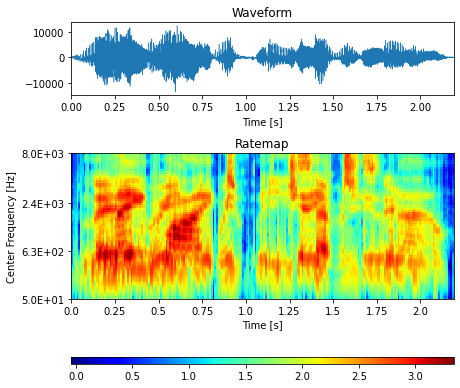

In [6]:
audio_url = (
    r"https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources"
    r"/ratemap/t29_lwwj2n_m17_lgwe7s.wav"
    )
data, sample_rate = ao.io.audio_read(audio_url)
frame_length = 10  # [ms]
frame_samples = int(
    np.ceil(frame_length / 1000 * sample_rate)
    )  # samples per frame
fig, axs = plt.subplots(
    3, 1, figsize=(6.5, 5.5), gridspec_kw={'height_ratios': [0.5, 1, 0.05]}
    )
# Signal
ao.plot.signal(data, sample_rate, ax=axs[0])
axs[0].set_title('Waveform')
# Gammatonegram
frame_length = 10  # [ms]
frame_samples = math.ceil(frame_length / 1000 * sample_rate)
plot, _ = ao.plot.gammatonegram(
    data,
    sample_rate,
    frame_samples,
    num_features=64,
    low_Hz=50,
    high_Hz=8000,
    pcolormesh_kwargs={'cmap': 'jet'},
    transform=np.log10,
    ax=axs[1]
    )
axs[1].set_title('Ratemap')
fig.colorbar(plot, cax=axs[2], orientation="horizontal")
fig.tight_layout()

One can see that our implementation corresponds with the example found in the
original implementation.

![Ratemap](https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources/ratemap/ratemap.png)


# Wheel Test Bed Experiments


## Experiment 0

In order to gather some data and test our initial hypothesis, we decided to
carry a simple experimetn with a single wheel test bed.


In [7]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment_0 = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-0"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment_0)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f'Invalid experiment folder {EXPERIMENT_FOLDER}')
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT0'
        )
DATA_FOLDER = EXPERIMENT_FOLDER / 'recordings'
recordings, naming = ao.dataset.utils.list_data(DATA_FOLDER)

c:\Users\esdan\Desktop\AO\venv\lib\site-packages\ao\dataset\utils.py:159: UserWarning: Could not parse VAO_2022-03-08_17-12-37 from VAO_2022-03-08_17-12-37, item VAO_2022-03-08_17-12-37 should be composed by one `key` and one `value` separated by a unique underscore but 2 `_` were found.
  warn(str(e))
c:\Users\esdan\Desktop\AO\venv\lib\site-packages\ao\dataset\utils.py:159: UserWarning: Could not parse VAO_2022-03-08_17-11-21 from VAO_2022-03-08_17-11-21, item VAO_2022-03-08_17-11-21 should be composed by one `key` and one `value` separated by a unique underscore but 2 `_` were found.
  warn(str(e))


In [8]:
# TODO show gammatonegram for some recordings

In [9]:
# TODO show gammatonegram for some recordings

In [10]:
def plot_primitive_experiment(audio_file, ax=None):
    data, sample_rate = ao.io.audio_read(audio_file)
    frame_length = 500  # [ms]
    frame_samples = int(
        np.ceil(frame_length / 1000 * sample_rate)
        )  # samples per frame
    return ao.plot.gammatonegram(
        data,
        sample_rate,
        frame_samples,
        num_features=64,
        low_Hz=0,
        high_Hz=22050,
        pcolormesh_kwargs={
            'cmap': 'jet',
            'vmin': -1
            },
        ax=ax
        )

In [11]:
data = pd.DataFrame.from_dict(recordings, orient='index')

In [12]:
# w_data = {}
# for c in data.values():
#     w_data[c['w']] = w_data.get(c['w'], []) + [c]
# fig, axs = plt.subplots(
#     len(w_data), max([len(v) for v in w_data.values()]), figsize=(15, 10)
#     )
# row = -1
# last_w = None
# for folder, experiment in data.items():
#     if last_w != experiment['w']:
#         row += 1
#         col = 0
#     else:
#         col += 1
#     last_w = experiment['w']
#     plot, ax = plot_primitive_experiment(
#         folder / 'audio0crop.wav', ax=axs[row, col]
#         )
#     ax.set_title(
#         ', '.join(
#             f"{k}={experiment[k]} {naming[k].get('unit', '')}"
#             for k in naming.keys()
#             )
#         )
# fig.colorbar(plot, cax=axs[-1, -1])
# fig.tight_layout()

## Experiment 1

In this experiment we improved the sensor setup, synchronization and control
with respect to the [Experiment 0](#experiment-0). This experiment was used to
develop a proof of concept for the Acoustic Odometry.


In [13]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment_0 = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-1"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment_0)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f"Invalid experiment folder {EXPERIMENT_FOLDER}")
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT1'
        )
DATA_FOLDER = EXPERIMENT_FOLDER / 'recordings'
recordings, naming = ao.dataset.utils.list_data(DATA_FOLDER)

In [14]:
sample_recording, recording_parameters = list(recordings.items())[1]


def get_recording_ground_truth(
        recording: Path, wheel_radius: float = 0.1
    ) -> pd.DataFrame:
    """Gets the ground truth of a training recording from its control file

    Args:
        recording (Path): Path to a training recording folder. Its
            corresponding control file must be located in the parent folder
            and have the same name as the recording folder.
        wheel_radius (float, optional): Effective radius of the wheel in [m].

    Returns:
        pd.DataFrame: Ground truth of the recording with columns 'ms', 'X',
            'Vx', 'Vw', 'slip', 'wheel_rotation' and 'timestamp' as index.
    """
    gt = pd.read_csv(
        recording.parent / (recording.name + '.csv'),
        index_col='timestamp',
        usecols=['timestamp', 'ms', 'X', 'Vx', 'Vw', 'wheel_rotation'],
        )
    # Remove the first row from the dataframe, the velocity there is useless
    gt = gt.iloc[1:, :]
    # Compute slip
    gt.loc[:, 'Vx_from_encoder'] = gt['Vw'].apply(np.deg2rad) * wheel_radius
    gt.loc[:, 'slip'] = (gt['Vx_from_encoder'] -
                         gt['Vx']) / gt[['Vx_from_encoder', 'Vx']].max(axis=1)
    gt.drop('Vx_from_encoder', axis=1, inplace=True)
    # Set the array read only
    gt.flags.writable = False
    return gt


sample_gt = get_recording_ground_truth(sample_recording)
sample_gt.iloc[35:45]

,ms,X,Vx,Vw,wheel_rotation,slip
timestamp,,,,,,
1.651142e+09,3600,123.67,0.0358,19.791,70.625,-0.035145
1.651142e+09,3701,127.13,0.0346,19.220,72.547,-0.030485
1.651142e+09,3801,130.33,0.0320,20.954,74.643,0.125005
1.651142e+09,3901,133.35,0.0302,18.936,76.536,0.086221
1.651142e+09,4001,136.42,0.0307,20.183,78.555,0.128484
1.651142e+09,4101,139.87,0.0345,20.107,80.565,0.016907
1.651142e+09,4201,143.25,0.0338,19.827,82.548,0.023252
1.651142e+09,4301,146.82,0.0357,19.763,84.524,-0.033811
1.651142e+09,4401,150.69,0.0387,20.746,86.599,-0.064377


In [15]:
def get_weighted_average(
    data: pd.DataFrame,
    var: str,
    start_timestamp: float,
    end_timestamp: float,
    ) -> float:
    df = data.loc[(data.index > start_timestamp) &
                  (data.index <= end_timestamp), [var, 'ms']]
    if df.empty:
        return 0
    # Weighted average of the Vx values giving more importance to the most
    # recent
    return (df[var] * df['ms']).sum() / df['ms'].sum()


get_weighted_average(
    sample_gt, 'Vx', sample_gt.iloc[35].name, sample_gt.iloc[40].name
    )

0.03239230966418867

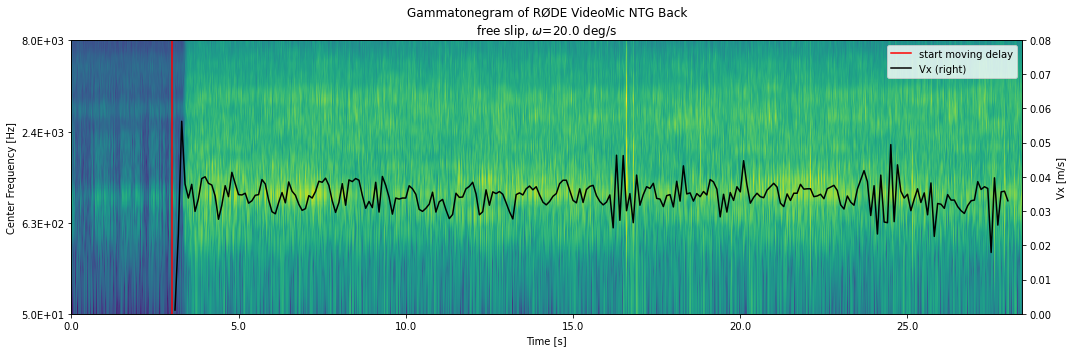

In [16]:
def plot_sample_audio(
    recording: Path,
    wav_file: str,
    frame_features: int = 256,
    frame_duration: int = 10,  # [milliseconds]
    # TODO use this to plot some segments and label theme with the average Vx
    segment_frames: int = 100,
    overlap_ratio: float = 0.8,
    show_segments: List[int] = [],
    ax: plt.Axes = None,
    ):
    gt = get_recording_ground_truth(recording)
    audio_path = recording / wav_file
    if ax is None:
        _, ax = plt.subplots(1, 1)
    audio, sample_rate = ao.io.audio_read(audio_path)
    config = ao.io.yaml_load(audio_path.with_suffix('.yaml'))
    ao.plot.gammatonegram(
        audio,
        ax=ax,
        sample_rate=sample_rate,
        frame_samples=int(frame_duration / 1000 * sample_rate),
        num_features=frame_features
        )
    params = ao.dataset.parse_filename(recording.name)
    # Show start delay
    ax.axvline(
        params['delay'] / frame_duration,
        color='r',
        label='start moving delay'
        )
    ax.legend()
    # Show Vx
    gt['time'] = (gt['ms'] + params['delay']) / 1000
    gt['frame'] = gt['time'] / frame_duration * 1000
    ax2 = gt.plot(y='Vx', x='frame', ax=ax, secondary_y=True, color='k')
    ax.set_xlabel('Time [s]')
    ax2.set_ylabel('Vx [m/s]')
    ax2.set_ylim(0, 0.08)
    # Show segments
    segment_overlap_frames = int(segment_frames * overlap_ratio)

    # Add title
    ax.set_title(
        f"Gammatonegram of {config['name']}\n"
        f"{'free slip' if np.isnan(params['s']) else 's=' + str(params['s']) }"
        f", $\omega$={params['w']} deg/s"
        )


plot_sample_audio(sample_recording, 'microphone2.wav')

## Experiment 2


In [19]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment_2 = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-2"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment_2)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f"Invalid experiment folder {EXPERIMENT_FOLDER}")
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT2'
        )
DATA_FOLDER = EXPERIMENT_FOLDER / 'recordings'
DATASETS_FOLDER = EXPERIMENT_FOLDER / 'datasets'
recordings, naming = ao.dataset.utils.list_data(DATA_FOLDER)

### Dataset generation


In [20]:
def _generate_dataset(
    recordings: List[Path],
    output_folder: Path,
    frame_features: int,
    frame_duration: int,
    segment_frames: int,
    segment_overlap_frames: int,
    extractors: List[Tuple[Type[ao.extractor.Extractor], dict]],
    wheel_radius: float = 0.10,
    *,
    transform: Optional[Callable[[np.ndarray, dict, pd.DataFrame],
                                 Tuple[np.ndarray, pd.DataFrame]]] = None,
    ) -> dict:
    """Generates a dataset in WebDataset format given a list of recordings, an
    output folder, a list of feature extractor classes and its initialization
    arguments and some additional parameters that concern the feature
    extraction. The dataset is divided in shards, each shard corresponds to a
    unique device from the recording. Each shard contains a list of segments
    with it's corresponding ground truth of longitudinal speed, wheel angular
    velocity and slip ratio. Segments can be overlapped. Each segment is
    composed by several frames. A frame is the result of extracting features
    over a determined number of audio samples that are determined by the frame
    duration.

    Args:
        recordings (List[Path]): List of recordings. Each recording is a path
            to a folder containing audio files with corresponding yaml files.
        output_folder (Path): Folder where to save the dataset shards.

        frame_features (int, optional): Number of features per frame.

        frame_duration (int, optional): Number of milliseconds per frame.
            Together with the sample rate, it will define the amount of samples
            used to extract features.
        segment_frames (int, optional): Number of frames per segment.

        segment_overlap_frames (int, optional): Amount of overlap frames
            between segments. 
        extractors (List[Tuple[Type[ao.extractor.Extractor], dict]], optional):
            Pairs of feature extractor classes and their initialization
            arguments. Defaults to [ (ao.extractor.GammatoneFilterbank, {}), ].
        wheel_radius (float, optional): Radius of the wheel in meters. Used in
            order to compute the ground truth slip ratio. Defaults to 0.1.
        transform (Optional[Callable[[np.ndarray, dict, pd.DataFrame],
            Tuple[np.ndarray, pd.DataFrame]]], optional): Callable to be
            applied to the audio signal and the ground truth with the goal of
            augmenting the data. The callable receives as input the audio
            signal array (n_channels x n_samples), the device configuration
            dictionary and the recording ground truth. It must return a tuple
            with the augmented audio signal and its corresponding ground truth.
            Defaults to None. 
        
    Raises:
        ValueError: If the transform function is a lambda function.
    
    Returns:
        dict: Dictionary with dataset creation details.
    """
    # Check input
    t_name = slugify(transform.__name__) if transform else 'None'
    if t_name == 'lambda':
        raise ValueError(
            "`transform` can't be a lambda function, because it is difficult "
            "to parse the source code of a lambda function: "
            f"{getsource(transform)}"
            )
    # Check if the output folder has already a dataset
    if any(output_folder.glob(f"transform_{t_name};*.tar")):
        warn(
            f"Dataset `{output_folder.name}` with transform `{t_name}` "
            f"already exists at {output_folder}"
            )
        return {}
    # Progress bars
    progress = {
        'recording':
            tqdm(total=len(recordings), desc='Recordings', unit='folder'),
        'file':
            tqdm(desc='microphone?', unit='file'),
        'segment':
            tqdm(
                desc='Write segments',
                unit='segments',
                bar_format='{desc}: {bar}{r_bar}'
                ),
        'features':
            tqdm(
                desc='Extract features',
                unit='frames',
                bar_format='{desc}: {bar}{r_bar}'
                ),
        }
    # Initialize variables used in the loop
    segment_duration = segment_frames * frame_duration / 1000  # in seconds
    segment_overlap_duration = segment_overlap_frames * frame_duration / 1000
    extractors_by_sample_rate = {}  # {sample_rate: [extractor, ...]}
    devices = {}
    # Iterate over recording folders
    try:
        for r_idx, recording in enumerate(recordings):
            # ! Hacky way to solve the synchronization issue
            delay_s = ao.dataset.parse_filename(recording.name)['delay'] / 1000
            # Wheel test bed control data
            try:
                ground_truth = get_recording_ground_truth(
                    recording, wheel_radius=wheel_radius
                    )
            except FileNotFoundError:
                warn(
                    "Skip: No control data found for recording " +
                    recording.name
                    )
                continue
            # Iterate over audio recordings
            wav_files = list(recording.glob('microphone*.wav'))
            progress['file'].reset(len(wav_files))
            for wav_file in wav_files:
                # Read data
                progress['file'].set_description(wav_file.name)
                wav_data, sample_rate = ao.io.audio_read(wav_file)
                file_config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
                if transform:
                    # ! Transform can mutate `ground_truth`
                    wav_data, wav_gt = transform(
                        wav_data, file_config, ground_truth
                        )
                else:
                    wav_gt = ground_truth
                if sample_rate != file_config['samplerate']:
                    warn(f"Skip: Sample rate mismatch for {wav_file.name}")
                    continue
                # Get or insert corresponding extractors
                try:
                    _extractors = extractors_by_sample_rate[sample_rate]
                except KeyError:
                    _extractors = extractors_by_sample_rate[sample_rate] = [
                        _class(
                            num_samples=int(
                                frame_duration * sample_rate / 1000
                                ),
                            num_features=frame_features,
                            sample_rate=sample_rate,
                            **_kwargs
                            ) for _class, _kwargs in extractors
                        ]
                # Get or insert corresponding writer
                d_name = slugify(file_config['name'])
                try:
                    device = devices[d_name]
                    # Check that the device configuration is the same. File
                    # configuration has `start_timestamp`, `end_timestamp` and
                    # `index` apart from the device configuration.
                    if not device['config'].items() <= file_config.items():
                        warn(
                            f"Configuration mismatch for {wav_file.name}:"
                            f"\nExpected {device['config']}\nGot {file_config}"
                            )
                except KeyError:
                    name = f"transform_{t_name};device_{d_name}"
                    device = devices[d_name] = {
                        'writer':
                            wds.ShardWriter(
                                str(output_folder / f"{name};shard_%03d.tar")
                                ),
                        'csv_file':
                            open(
                                output_folder / f"{name}.csv", 'w', newline=''
                                ),
                        'config': {
                            k: v
                            for k, v in file_config.items()
                            if 'timestamp' not in k and 'index' not in k
                            },
                        }
                    device['csv_writer'] = csv.DictWriter(
                        device['csv_file'],
                        fieldnames=[
                            'shard', 'recording', 'segment', 'Vx', 'Vw', 'slip'
                            ]
                        )
                    device['csv_writer'].writeheader()
                progress['features'].reset(total=1)
                # Process all features: shape=(channels x features x frames)
                features = ao.dataset.audio.features(wav_data, _extractors)
                n_frames = features.shape[2]
                # ? Should features be normalized ?
                # Small trick to obtain the metric of frames per second
                progress['features'].total = n_frames
                progress['features'].update(n_frames)
                # Generate overlapped segments from the features
                step = segment_frames - segment_overlap_frames
                num_segments = int((n_frames - segment_frames) / step)
                segments = [
                    features[:, :, n * step:n * step + segment_frames]
                    for n in range(num_segments)
                    ]
                # Recordings are not properly synchronized, approximation
                # start = file_config['start_timestamp']
                start = wav_gt.index[0] - delay_s
                progress['segment'].reset(total=len(segments))
                for idx, segment in enumerate(segments):
                    end = start + segment_duration
                    result = {
                        var: get_weighted_average(wav_gt, var, start, end)
                        for var in ['Vx', 'Vw', 'slip']
                        }
                    device['writer'].write({
                        '__key__':
                            f"transform_{t_name};device_{d_name};"
                            f"recording_{r_idx};segment_{idx}",
                        'npy': segment,
                        'json': result,
                        })
                    device['csv_writer'].writerow({
                        'shard': device['writer'].shard - 1,
                        'recording': r_idx,
                        'segment': idx,
                        **result
                        })
                    start = end - segment_overlap_duration
                progress['segment'].update(len(segments))
                progress['file'].update()
            progress['recording'].update()
    finally:
        # Cleanup
        for device in devices.values():
            device['writer'].close()
            device['csv_file'].close()
        for progress_bar in progress.values():
            progress_bar.close()
    # Build dataset details
    out = {'devices': {}, 'transforms': {}, 'shards': {}}
    out['transforms'][t_name] = getsource(transform) if transform else 'None'
    for d_name, device in devices.items():
        out['devices'][d_name] = device['config']
        samples = pd.read_csv(device['csv_file'].name)
        for idx, shard_samples in samples.groupby('shard'):
            fname = f"transform_{t_name};device_{d_name};shard_{idx:03d}.tar"
            out['shards'][fname] = {
                'transform': t_name,
                'device': d_name,
                'shard': idx,
                'count': len(shard_samples),
                }
    return out

In [21]:
def generate_dataset(
    recordings: List[Path],
    name: str,
    frame_features: int = 256,
    frame_duration: int = 10,
    segment_frames: int = 100,
    overlap_ratio: float = 0.8,
    wheel_radius: float = 0.1,
    *,
    datasets_folder: Path = DATASETS_FOLDER,
    extractors: List[Tuple[Type[ao.extractor.Extractor], dict]] = [
        (ao.extractor.GammatoneFilterbank, {}),
        ],
    ) -> Path:
    """Uses the `_generate_dataset` function to generate a dataset a dataset
    without any data augmentation.

    Args:
        recordings (List[Path]): List of recordings. Each recording is a path
            to a folder containing audio files with corresponding yaml files.
        name (str): Name of the dataset. If datasets_folder contains a
            subfolder with the same name, the dataset won't be created.
        frame_features (int, optional): Number of features per frame. Defaults
            to 256.
        frame_duration (int, optional): Number of milliseconds per frame.
            Defaults to 10. Together with the sample rate, it will define the
            amount of samples used to extract features.
        segment_frames (int, optional): Number of frames per segment.
            Defaults to 100.
        overlap_ratio (float, optional): Ratio of overlap between segments.
            Defaults to 0.8. 
        wheel_radius (float, optional): Radius of the wheel in meters. Used in
            order to compute the ground truth slip ratio. Defaults to 0.1.
        datasets_folder (Path, optional): Folder where to write the datasets.
            Defaults to DATASETS_FOLDER. 
        extractors (List[Tuple[Type[ao.extractor.Extractor], dict]], optional):
            Pairs of feature extractor classes and their initialization
            arguments. Defaults to [ (ao.extractor.GammatoneFilterbank, {}), ].

    Raises:
        ValueError: If datasets_folder is not a valid folder. Or if extractor
            initialization arguments contain a lambda function.

    Returns:
        Path: Path to the written dataset under datasets_folder.
    """
    # Check input
    if not datasets_folder.is_dir():
        raise ValueError(
            f"datasets_folder must be a directory, not {datasets_folder}"
            )
    output_folder = Path(datasets_folder) / name
    output_folder.mkdir(exist_ok=True, parents=True)
    # Check dataset generation data
    segment_overlap_frames = int(segment_frames * overlap_ratio)
    extractors_list = []
    for i, (extractor_class, kwargs) in enumerate(extractors):
        _kwargs = {}
        for k, v in kwargs.items():
            if callable(v):
                if v.__name__ == 'lambda':
                    raise ValueError(
                        f"`{k}` can't be a lambda function, because it is "
                        "difficult to parse the source code of a lambda "
                        f"function: {getsource(v)}"
                        )
                _kwargs[k] = getsource(v)
            else:
                _kwargs[k] = v
        extractors_list.append({
            'class': extractor_class.__name__,
            'kwargs': _kwargs,
            })
    # Generate dataset
    details = _generate_dataset(
        recordings=recordings,
        output_folder=output_folder,
        frame_features=frame_features,
        frame_duration=frame_duration,
        segment_frames=segment_frames,
        segment_overlap_frames=segment_overlap_frames,
        extractors=extractors,
        transform=None,
        )
    # Save dataset configuration
    if details:  # If a dataset was generated, details is not empty
        ao.io.yaml_dump(
            {
                'recordings': [r.name for r in recordings],
                'frame_features': frame_features,
                'frame_duration': frame_duration,
                'segment_frames': segment_frames,
                'overlap_ratio': overlap_ratio,
                'segment_overlap_frames': segment_overlap_frames,
                'extractors': extractors_list,
                'wheel_radius': wheel_radius,
                **details
                },
            to_file=output_folder / 'dataset.yaml',
            )
    return output_folder


def log10(features: np.ndarray) -> np.ndarray:
    return np.log10(features)


dataset_path = generate_dataset(
    list(recordings.keys())[0:1],
    'test',
    frame_features=256,
    frame_duration=10,  # [milliseconds]
    segment_frames=100,
    overlap_ratio=0.8,
    extractors=[
        (
            ao.extractor.GammatoneFilterbank,
            {
                'transform': log10,
                'on_channel': -1,  # Average
                'low_Hz': 50,
                'high_Hz': 8000,
                'temporal_integration': 0
                }
            ),
        ],
    )

Recordings:   0%|          | 0/1 [00:00<?, ?folder/s]

microphone?: 0file [00:00, ?file/s]

Write segments:           | 0/? [00:00<?, ?segments/s]

Extract features:           | 0/? [00:00<?, ?frames/s]

# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_None;device_laptop-built-in-microphone;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_None;device_rode-smartlav-top;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_None;device_rode-smartlav-wheel-axis;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_None;device_rode-videomic-ntg-top;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_None;device_rode-videomic-ntg-front;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_None;device_rode-videomic-ntg-back;shard_000.tar 0 0.0 GB 0


### Visualization


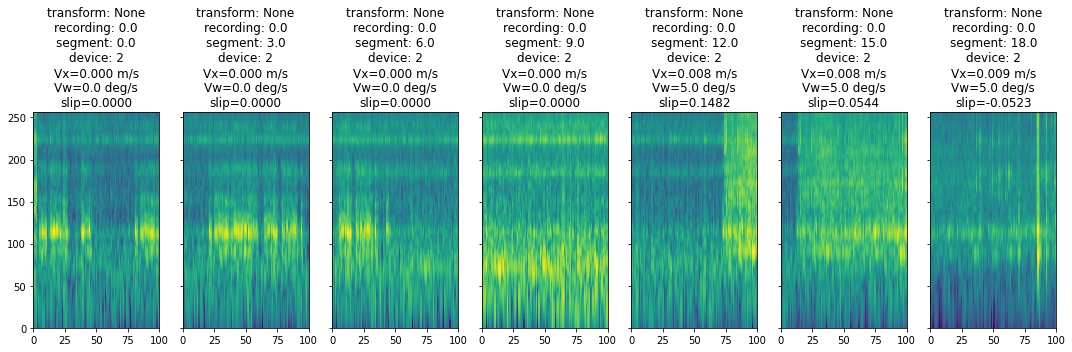

In [22]:
def get_config(dataset_path: Path) -> dict:
    return ao.io.yaml_load(dataset_path / 'dataset.yaml')


def show_dataset_samples(
    dataset_path: Path,
    shard_filter: Callable[[dict], bool] = lambda params: True,
    samples: Union[int, List[int]] = 6,
    ):
    config = get_config(dataset_path)
    shards = {
        dataset_path / name: params
        for name, params in config['shards'].items() if shard_filter(params)
        }
    if not shards:
        raise ValueError(
            f"No shards found in {dataset_path} with provided filter"
            )
    # If samples is an integer, shuffle the data
    shuffle = 0
    if isinstance(samples, int):
        shuffle = 10E6
        samples = range(samples)
    dataset = wds.DataPipeline(
        wds.SimpleShardList([f"file:{path}" for path in shards.keys()]),
        wds.tarfile_to_samples(),
        wds.decode(
            wds.handle_extension('.npy', lambda x: np.load(io.BytesIO(x)))
            ),
        wds.to_tuple('__key__', 'npy', 'json'),
        wds.shuffle(shuffle),
        )
    dataset = dataset.with_length(sum([s['count'] for s in shards.values()]))
    segment_duration = config['segment_frames'] * config['frame_duration']
    segment_overlap_duration = int(segment_duration * config['overlap_ratio'])
    # Plot random samples
    num_extractors = len(config['extractors'])
    _, axs = plt.subplots(
        num_extractors, len(samples), squeeze=False, sharex=True, sharey=True
        )
    for idx, (key, features, sample) in enumerate(dataset):
        try:
            col = samples.index(idx)
        except ValueError:
            continue
        for row in range(num_extractors):
            axs[row][col].pcolormesh(features[row, :, :], shading='flat')
        params = ao.dataset.parse_filename(key)
        device = list(config['devices'].keys()).index(params['device'])
        axs[0][col].set_title(
            '\n'.join([
                f"transform: {params['transform']}",
                f"recording: {params['recording']}",
                # TODO add seconds here
                f"segment: {params['segment']}",
                f"device: {device}",
                f"Vx={sample['Vx']:0.3f} m/s",
                f"Vw={sample['Vw']:0.1f} deg/s",
                f"slip={sample['slip']:0.4f}",
                ])
            )


show_dataset_samples(
    dataset_path,
    shard_filter=lambda d: 'smartlav-wheel' in d['device'],
    samples=range(0, 20, 3),
    )

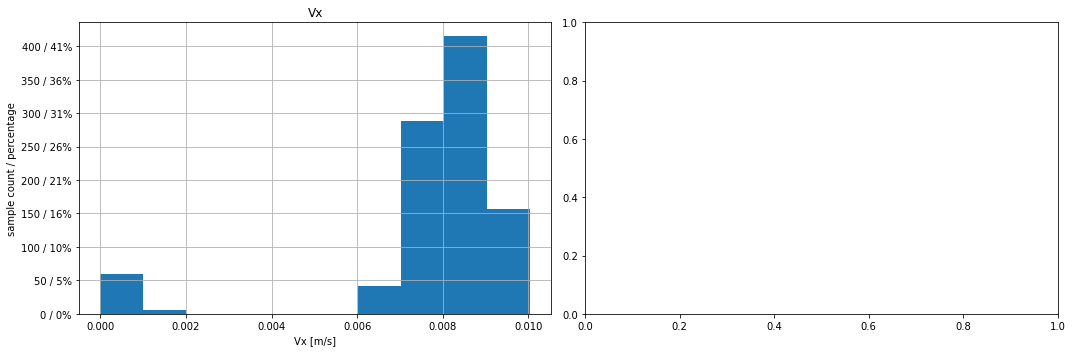

In [23]:
def get_data_list(
        dataset_path: Path, shard_filter: Callable[[dict], bool]
    ) -> pd.DataFrame:
    config = get_config(dataset_path)
    shards = {
        dataset_path / name: params
        for name, params in config['shards'].items() if shard_filter(params)
        }
    if not shards:
        raise ValueError(
            f"No shards found in {dataset_path} with given filter."
            )
    data = []
    for shard in shards.values():
        if shard['shard'] > 0:
            continue
        fname = f"transform_{shard['transform']};device_{shard['device']}.csv"
        data.append(
            pd.read_csv(
                dataset_path / fname
                ).assign(transform=shard['transform'], device=shard['device'])
            )
    return pd.concat(data, ignore_index=True)


def plot_data_histogram(
    data: pd.DataFrame,
    bins: Union[int, List[float]] = 10,
    ax_Vx: plt.Axes = None,
    ax_Vw: plt.Axes = None,
    ) -> Tuple[plt.Figure, Tuple[plt.Axes, plt.Axes]]:
    if not ax_Vx and not ax_Vw:
        fig, (ax_Vx, ax_Vw) = plt.subplots(1, 2)
    elif ax_Vx:
        fig = ax_Vx.get_figure()
    else:
        fig = ax_Vw.get_figure()
    total = len(data.index)
    # Plot Vx histogram
    if ax_Vx:
        ax_Vx.yaxis.set_major_formatter(
            ticker.
            FuncFormatter(lambda x, pos: f"{x:.0f} / {x / total * 100:.0f}%")
            )
        data.hist(ax=ax_Vx, column='Vx', bins=bins)
        ax_Vx.set_ylabel('sample count / percentage')
        ax_Vx.set_xlabel('Vx [m/s]')
    # TODO plot Vw vs slip histogram
    return fig, (ax_Vx, ax_Vw)


def show_dataset_stats(
    dataset_path: Path,
    shard_filter: Callable[[dict], bool] = lambda params: True,
    bins: Union[int, List[float]] = 10,
    ax_Vx: plt.Axes = None,
    ax_Vw: plt.Axes = None,
    ):
    data = get_data_list(dataset_path, shard_filter)
    plot_data_histogram(data, bins=bins, ax_Vx=ax_Vx, ax_Vw=ax_Vw)


show_dataset_stats(dataset_path)

In [24]:
def show_dataset(
    dataset_path,
    shard_filter: Callable[[dict], bool] = lambda params: True,
    samples: Union[int, List[float]] = 6,
    bins: Union[int, List[float]] = 10,
    ):
    # TODO create a figure with subfigures
    show_dataset_samples(dataset_path, shard_filter, samples=samples)
    show_dataset_stats(dataset_path, shard_filter, bins=bins)

### Data agumentation


Recordings:   0%|          | 0/1 [00:00<?, ?folder/s]

microphone?: 0file [00:00, ?file/s]

Write segments:           | 0/? [00:00<?, ?segments/s]

Extract features:           | 0/? [00:00<?, ?frames/s]

# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_average-channels;device_laptop-built-in-microphone;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_average-channels;device_rode-smartlav-top;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_average-channels;device_rode-smartlav-wheel-axis;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_average-channels;device_rode-videomic-ntg-top;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_average-channels;device_rode-videomic-ntg-front;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_average-channels;device_rode-videomic-ntg-back;shard_000.tar 0 0.0 GB 0


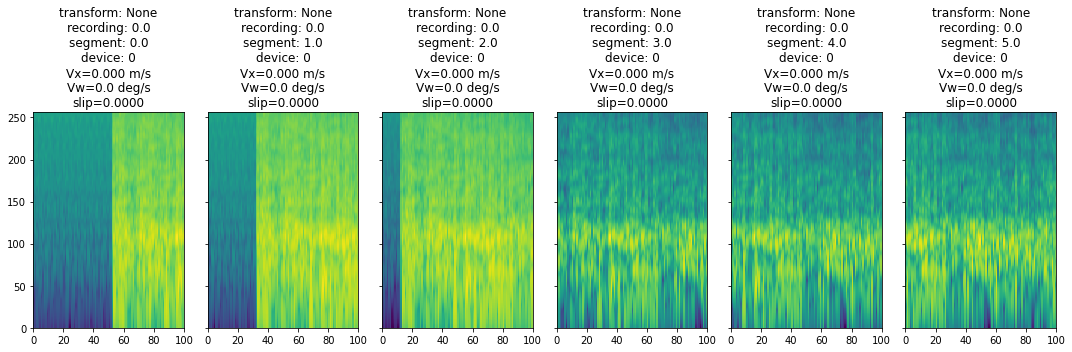

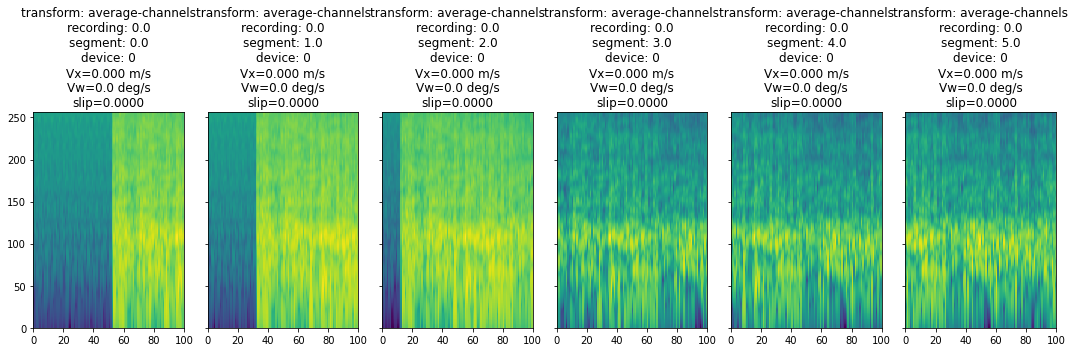

In [25]:
def augment_dataset(
    dataset_path: Path,
    data_folder: Path = DATA_FOLDER,
    transform: Optional[Callable[[np.ndarray, dict, pd.DataFrame],
                                 Tuple[np.ndarray, pd.DataFrame]]] = None,
    ):
    """Applies a given transform function to a dataset. Feature
    extraction parameters will be taken from the dataset config file.

    Args:
        dataset_path (Path): Path to the dataset to augment.

        data_folder (Path, optional): Path to the folder where to find the
            recordings used in the dataset that should be augmented. Defaults
            to DATA_FOLDER.
        transform (Optional[Callable[[np.ndarray, dict, pd.DataFrame],
            Tuple[np.ndarray, pd.DataFrame]]], optional): Callable to be
            applied to the audio signal and the ground truth with the goal of
            augmenting the data. The callable receives as input the audio
            signal array (n_channels x n_samples), the device configuration
            dictionary and the recording ground truth. It must return a tuple
            with the augmented audio signal and its corresponding ground truth.
            Defaults to None. 

    Raises:
        RuntimeError: If a recording from the dataset configuration can't be
            found in the provided data folder.
        RuntimeError: If an extractor specified in the dataset configuration
            can't be found int the available extractors.
    """
    # Get dataset configuration
    config = ao.io.yaml_load(dataset_path / 'dataset.yaml')
    # Build dataset generation input from dataset configuration
    recordings = []
    for recording_name in config['recordings']:
        recording = data_folder / recording_name
        if not recording.is_dir():
            raise RuntimeError(
                f"Recording {recording_name} not found in {data_folder}"
                )
        recordings.append(recording)
    extractors = []
    for extractor in config['extractors']:
        # Get the extractor class
        try:
            extractor_class = getattr(ao.extractor, extractor['class'])
        except AttributeError as e:
            raise RuntimeError(
                f"Extractor `{extractor['class']}` not found: {e}"
                )
        # Get the extractor keyword arguments
        _kwargs = {}
        for key, arg in extractor['kwargs'].items():
            # Check if the argument is a function source
            if isinstance(arg, str):
                match = re.search(r"def (?P<function_name>.*)\(", arg)
                if match:
                    # If it is function source, execute it and get the function
                    # handle
                    # ! This code is unsafe, it could be tricked by a
                    # ! maliciously built config file
                    exec(arg)
                    _kwargs[key] = eval(match.group('function_name'))
                    continue
            _kwargs[key] = arg
        extractors.append((extractor_class, _kwargs))
    # Generate dataset
    details = _generate_dataset(
        recordings=recordings,
        output_folder=dataset_path,
        frame_features=config['frame_features'],
        frame_duration=config['frame_duration'],
        segment_frames=config['segment_frames'],
        segment_overlap_frames=config['segment_overlap_frames'],
        extractors=extractors,
        wheel_radius=config['wheel_radius'],
        transform=transform,
        )
    # Save augmented dataset configuration
    for key, value in details.items():
        config[key].update(value)
    ao.io.yaml_dump(config, dataset_path / 'dataset.yaml')


def average_channels(
    audio: np.ndarray,
    device_config: dict,
    ground_truth: pd.DataFrame,
    ) -> Tuple[np.ndarray, pd.DataFrame]:
    return np.atleast_2d(audio.mean(axis=0)), ground_truth


augment_dataset(dataset_path, transform=average_channels)
for name in ['None', 'average-channels']:
    show_dataset_samples(
        dataset_path,
        shard_filter=lambda d: d['transform'] == name,
        samples=range(6),
        )

Recordings:   0%|          | 0/1 [00:00<?, ?folder/s]

microphone?: 0file [00:00, ?file/s]

Write segments:           | 0/? [00:00<?, ?segments/s]

Extract features:           | 0/? [00:00<?, ?frames/s]

# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_noise-snr-01;device_laptop-built-in-microphone;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_noise-snr-01;device_rode-smartlav-top;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_noise-snr-01;device_rode-smartlav-wheel-axis;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_noise-snr-01;device_rode-videomic-ntg-top;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_noise-snr-01;device_rode-videomic-ntg-front;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test\transform_noise-snr-01;device_rode-videomic-ntg-back;shard_000.tar 0 0.0 GB 0


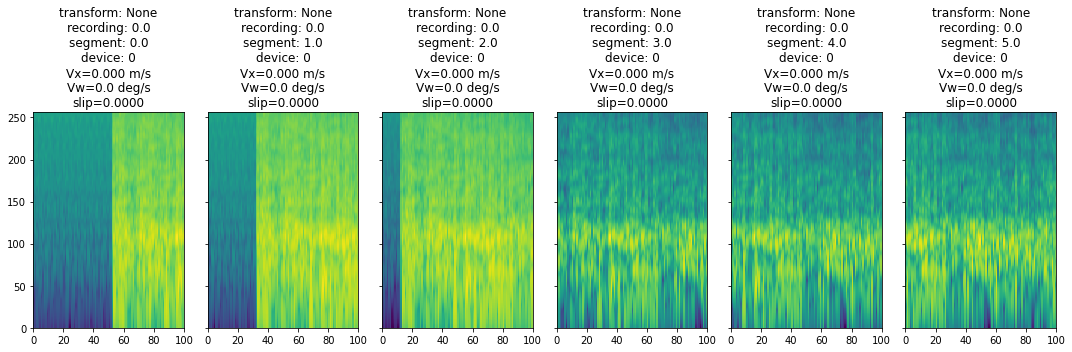

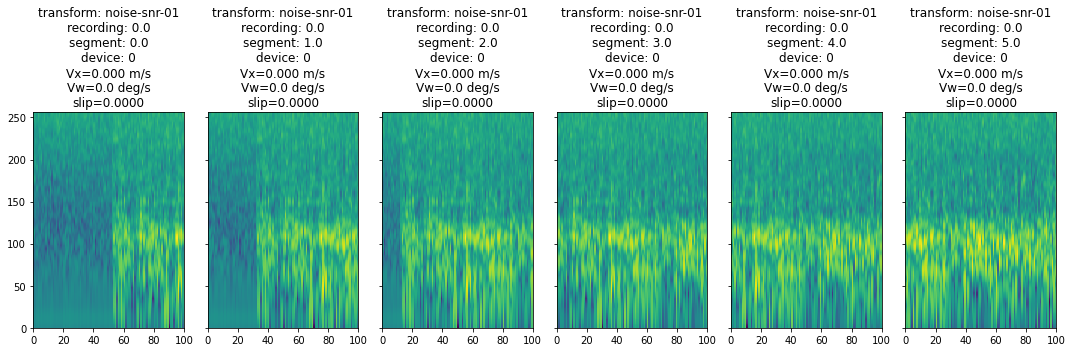

In [26]:
def noise_snr_01(
    audio: np.ndarray,
    device_config: dict,
    ground_truth: pd.DataFrame,
    ) -> Tuple[np.ndarray, pd.DataFrame]:
    snr = 0.1
    # https://github.com/SuperKogito/pydiogment/blob/074543dc9483b450653f8a00c8279bf1eb873199/pydiogment/auga.py#L36
    # ! Important to keep the float64 type of audio
    noise = np.random.rand(*audio.shape).astype(np.float64)
    # compute powers
    noise_power = np.mean(np.power(noise, 2))
    audio_power = np.mean(np.power(audio, 2))
    # compute snr and scaling factor
    snr_linear = 10**(snr / 10.0)
    noise_factor = (audio_power / noise_power) * (1 / snr_linear)
    # add noise
    # ! Important in place operation in order to keep the memory layout.
    # ! Extractor only works with one memory layout at the moment.
    audio += np.sqrt(noise_factor) * noise
    return audio, ground_truth


augment_dataset(dataset_path, transform=noise_snr_01)

# TODO format in a single plot for the report
for name in ['None', 'noise-snr-01']:
    show_dataset_samples(
        dataset_path,
        shard_filter=lambda d: d['transform'] == name,
        samples=range(6)
        )


# Datasets


### Feature transforms


In [26]:
def log10(features: np.ndarray) -> np.ndarray:
    return np.log10(features)

### Audio augmentation transforms


In [27]:
def add_random_snr_noise(
    audio: np.ndarray,
    device_config: dict,
    ground_truth: pd.DataFrame,
    ) -> Tuple[np.ndarray, pd.DataFrame]:
    snr = np.random.uniform(0, 1)
    # https://github.com/SuperKogito/pydiogment/blob/074543dc9483b450653f8a00c8279bf1eb873199/pydiogment/auga.py#L36
    # ! Keep the float64 type of audio. Extractor only works with doubles at
    # ! the moment.
    noise = np.random.rand(*audio.shape).astype(np.float64)
    # compute powers
    noise_power = np.mean(np.power(noise, 2))
    audio_power = np.mean(np.power(audio, 2))
    # compute snr and scaling factor
    snr_linear = 10**(snr / 10.0)
    noise_factor = (audio_power / noise_power) * (1 / snr_linear)
    # add noise
    # ! In place operation in order to keep the memory layout. Extractor only
    # ! works with one memory layout at the moment.
    audio += np.sqrt(noise_factor) * noise
    return audio, ground_truth


def add_random_gain(
    audio: np.ndarray,
    device_config: dict,
    ground_truth: pd.DataFrame,
    ) -> Tuple[np.ndarray, pd.DataFrame]:
    raise NotImplementedError()


def normalize(
    audio: np.ndarray,
    device_config: dict,
    ground_truth: pd.DataFrame,
    ) -> Tuple[np.ndarray, pd.DataFrame]:
    raise NotImplementedError()

## Base


C:\Users\esdan\AppData\Local\Temp\ipykernel_14524\2029145830.py:69: UserWarning: Dataset `base` with transform `None` already exists at G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\base
  warn(


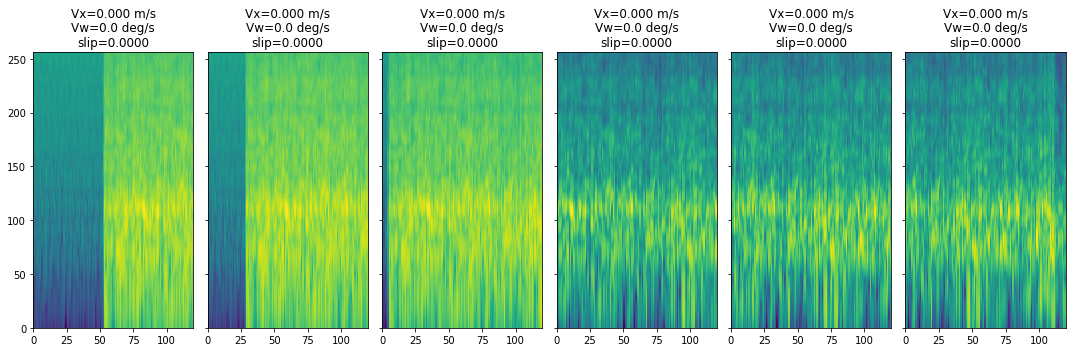

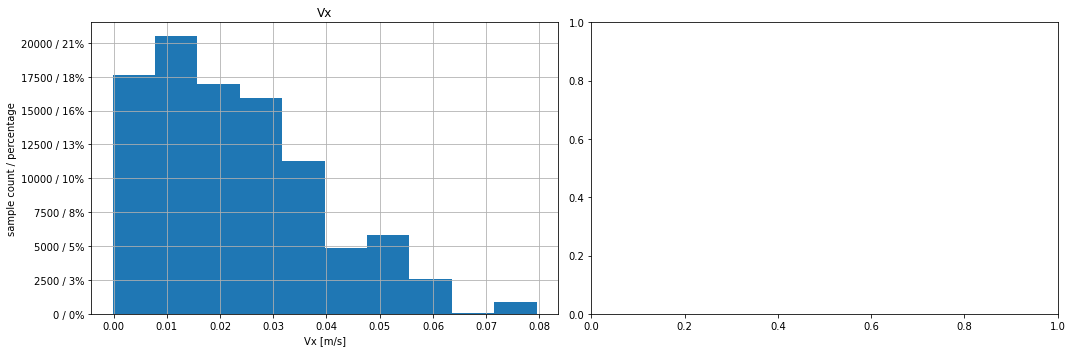

In [45]:
dataset_path = generate_dataset(
    list(recordings.keys()),
    'base',
    frame_features=256,
    frame_duration=10,  # [milliseconds]
    segment_frames=120,
    overlap_ratio=0.8,
    extractors=[
        (
            ao.extractor.GammatoneFilterbank,
            {
                'transform': log10,
                'on_channel': -1,  # Average
                'low_Hz': 50,
                'high_Hz': 8000,
                'temporal_integration': 0
                }
            ),
        ],
    )
show_dataset(dataset_path, bins=10)

In [ ]:
augment_dataset(dataset_path, transform=add_random_snr_noise)
show_dataset(dataset_path)

### Only positive slip ratios


C:\Users\esdan\AppData\Local\Temp\ipykernel_23352\2029145830.py:69: UserWarning: Dataset `legacy` with transform `None` already exists at G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\legacy
  warn(


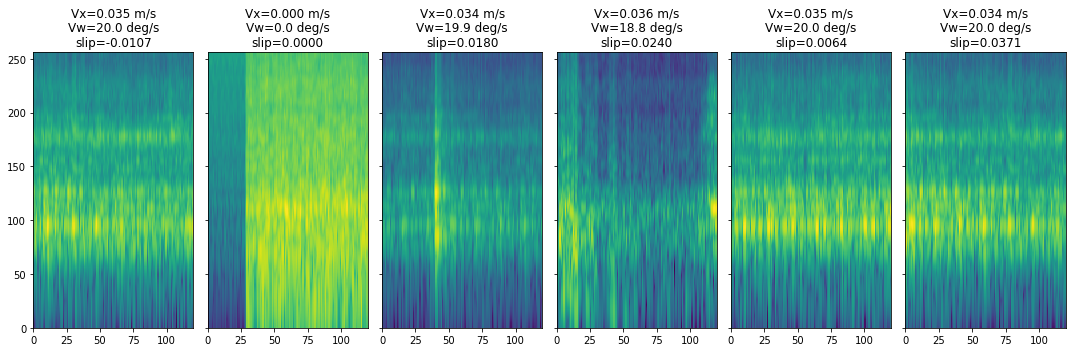

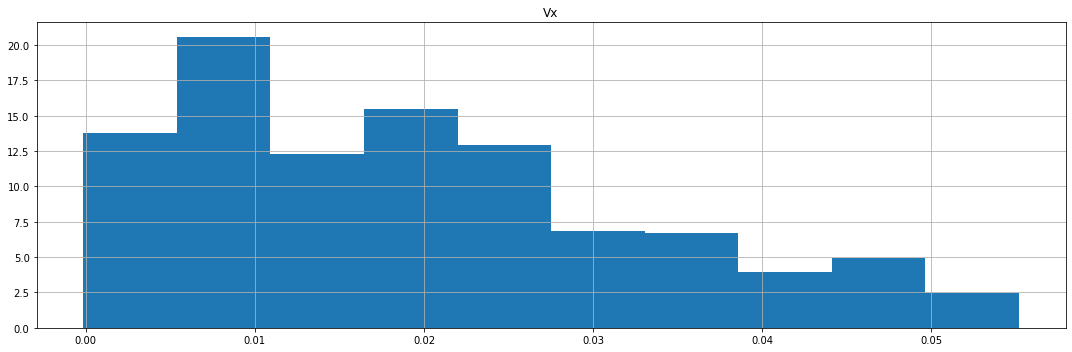

In [30]:
dataset_path = generate_dataset(
    [r for r, d in recordings.items() if np.isnan(d['s']) or d['s'] >= 0],
    'no-negative-slip',
    frame_features=256,
    frame_duration=10,  # [milliseconds]
    segment_frames=120,
    overlap_ratio=0.8,
    extractors=[
        (
            ao.extractor.GammatoneFilterbank,
            {
                'transform': log10,
                'on_channel': -1,  # Average
                'low_Hz': 50,
                'high_Hz': 8000,
                'temporal_integration': 0
                }
            ),
        ],
    )
show_dataset(dataset_path)

### Shorter segment


C:\Users\esdan\AppData\Local\Temp\ipykernel_15192\3758450214.py:56: UserWarning: Dataset already exists at G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\raw-segment-120
  warn(f"Dataset already exists at {output_folder}")


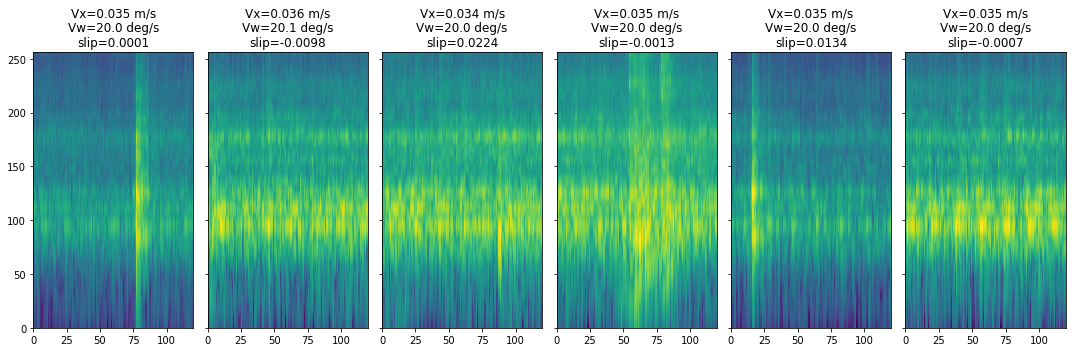

In [53]:
dataset_path = generate_dataset(
    list(recordings.keys()),
    'segment-100',
    frame_features=256,
    frame_duration=10,  # [milliseconds]
    segment_frames=100,
    overlap_ratio=0.8,
    extractors=[
        (
            ao.extractor.GammatoneFilterbank,
            {
                'transform': log10,
                'on_channel': -1,  # Average
                'low_Hz': 50,
                'high_Hz': 8000,
                'temporal_integration': 0
                }
            ),
        ],
    )
show_dataset_samples(dataset_path)

### Reduced frame duration


C:\Users\esdan\AppData\Local\Temp\ipykernel_15192\3758450214.py:56: UserWarning: Dataset already exists at G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\raw-duration-5
  warn(f"Dataset already exists at {output_folder}")


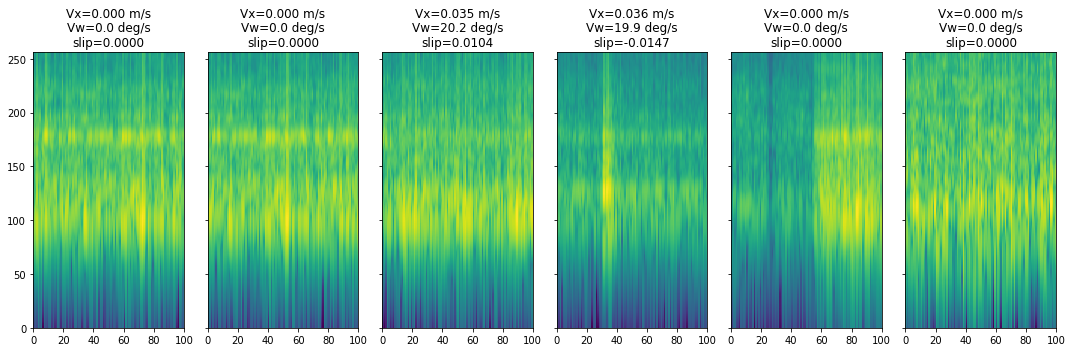

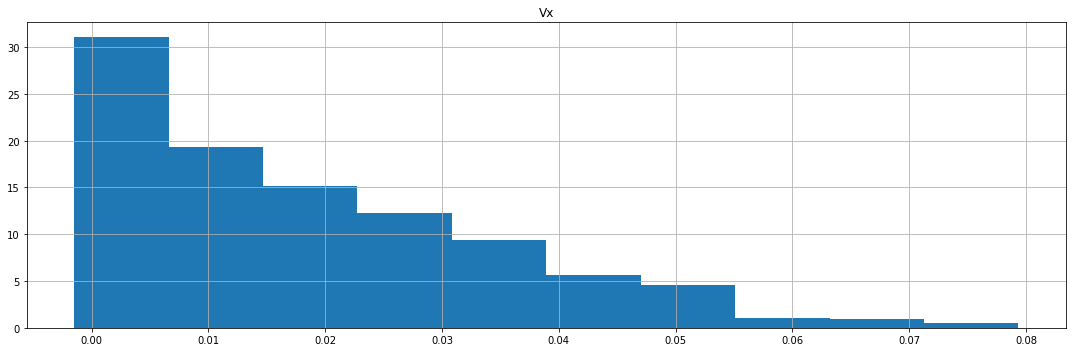

In [57]:
dataset_path = generate_dataset(
    list(recordings.keys()),
    'duration-5',
    frame_features=256,
    frame_duration=5,  # [milliseconds]
    segment_frames=120,
    overlap_ratio=0.8,
    extractors=[
        (
            ao.extractor.GammatoneFilterbank,
            {
                'transform': log10,
                'on_channel': -1,  # Average
                'low_Hz': 50,
                'high_Hz': 8000,
                'temporal_integration': 0
                }
            ),
        ],
    )
show_dataset(dataset_path)


## Double channel


C:\Users\esdan\AppData\Local\Temp\ipykernel_15192\3758450214.py:56: UserWarning: Dataset already exists at G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\raw-double-channel
  warn(f"Dataset already exists at {output_folder}")


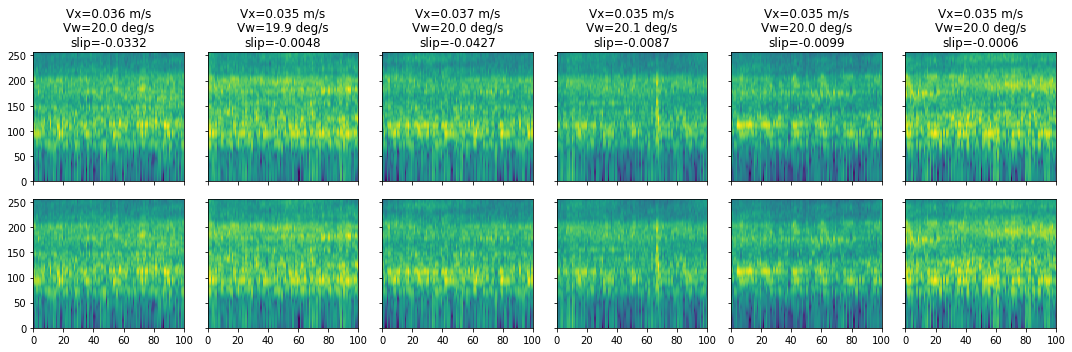

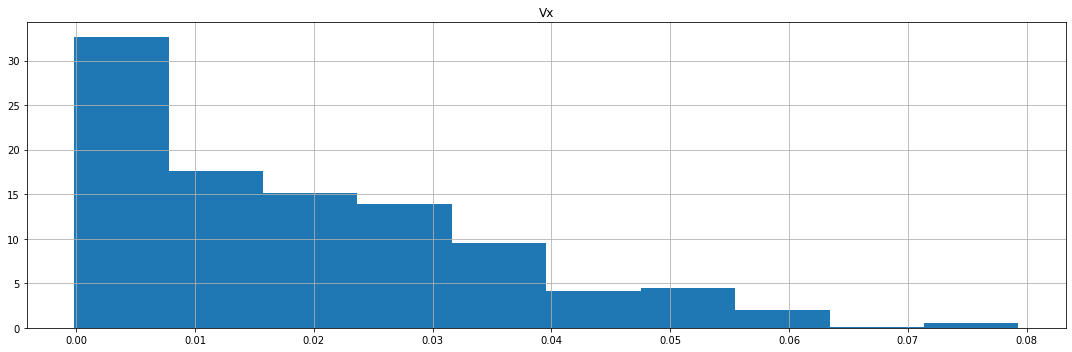

In [61]:
dataset_path = generate_dataset(
    list(recordings.keys()),
    'double-channel',
    frame_features=256,
    frame_duration=10,  # [milliseconds]
    segment_frames=120,
    overlap_ratio=0.8,
    extractors=[
        (
            ao.extractor.GammatoneFilterbank, {
                'transform': log10,
                'on_channel': 0,
                'low_Hz': 50,
                'high_Hz': 8000,
                'temporal_integration': 0
                }
            ),
        (
            ao.extractor.GammatoneFilterbank, {
                'transform': log10,
                'on_channel': 1,
                'low_Hz': 50,
                'high_Hz': 8000,
                'temporal_integration': 0
                }
            ),
        ],
    )
show_dataset(dataset_path)